# Predict Future Sales - Base 1

In [1]:
# packages
import numpy as np
import pandas as pd

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

from itertools import product
import statsmodels.api as sm

from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from xgboost import XGBRegressor
from xgboost import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

import time
import sys
import gc
import pickle
sys.version_info

sys.version_info(major=3, minor=7, micro=9, releaselevel='final', serial=0)

In [2]:
# import datasets
import os 

PATH = os.getenv('HOME')+'/aiffel/kaggle-predict-future-sales-master/data/'
sample_sub = pd.read_csv(PATH+'sample_submission.csv')

items = pd.read_csv(PATH+'items.csv')
shops = pd.read_csv(PATH+'shops.csv')
cats = pd.read_csv(PATH+'item_categories.csv')
train = pd.read_csv(PATH+'sales_train.csv')
# set index to ID to avoid droping it later
test  = pd.read_csv(PATH+'test.csv').set_index('ID')

In [3]:
# 데이터 형태 확인 
print("Shape of train:", train.shape)
print("Shape of test:", test.shape)
print("Shape of shops:", shops.shape)
print("Shape of items:", items.shape)
print("Shape of item_categories:", cats.shape)

Shape of train: (2935849, 6)
Shape of test: (214200, 2)
Shape of shops: (60, 2)
Shape of items: (22170, 3)
Shape of item_categories: (84, 2)


In [4]:
train.head()
#train.count()     #데이터 건수 확인

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [5]:
# 날짜데이터를 Datetime 형식으로 바꿔줍니다.
train.loc[:,'date'] = pd.to_datetime(train.date)

# 데이터의 정합성을 확인합니다
train.isna().sum()

#날짜형으로 바뀐 date 확인
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-02-01,0,59,22154,999.00,1.0
1,2013-03-01,0,25,2552,899.00,1.0
2,2013-05-01,0,25,2552,899.00,-1.0
3,2013-06-01,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


In [6]:
test.head()

,shop_id,item_id
ID,,
0,5,5037
1,5,5320
2,5,5233
3,5,5232
4,5,5268


In [7]:
shops.sample(10)
#러시아어로 된 상점 이름 

,shop_name,shop_id
36,"Новосибирск ТРЦ ""Галерея Новосибирск""",36
18,"Красноярск ТЦ ""Июнь""",18
51,"Тюмень ТЦ ""Зеленый Берег""",51
35,"Н.Новгород ТРЦ ""Фантастика""",35
44,"Самара ТЦ ""Мелодия""",44
19,"Курск ТЦ ""Пушкинский""",19
22,Москва Магазин С21,22
5,"Вологда ТРЦ ""Мармелад""",5
2,"Адыгея ТЦ ""Мега""",2
33,"Мытищи ТРК ""XL-3""",33


In [8]:
shops.dtypes

shop_name    object
shop_id       int64
dtype: object

In [9]:
items.head()
#러시아어로 된 물품명

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [10]:
cats.head()
#러시아어로 된 카테고리명
#cats.count()       #갯수 확인

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [11]:
#데이터 통계값 확인하기 
train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


In [12]:
train.info()      #데이터 정보 확인 (자료형 확인)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   date_block_num  int64         
 2   shop_id         int64         
 3   item_id         int64         
 4   item_price      float64       
 5   item_cnt_day    float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB


In [13]:
print("No. of Null values in the train set :", train.isnull().sum().sum())
print("No. of Null values in the test set :", test.isnull().sum().sum())
print("No. of Null values in the item set :", items.isnull().sum().sum())
print("No. of Null values in the shops set :", shops.isnull().sum().sum())
print("No. of Null values in the item_categories set :", cats.isnull().sum().sum())

No. of Null values in the train set : 0
No. of Null values in the test set : 0
No. of Null values in the item set : 0
No. of Null values in the shops set : 0
No. of Null values in the item_categories set : 0


/home/aiffel-dj56/anaconda3/envs/aiffel/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


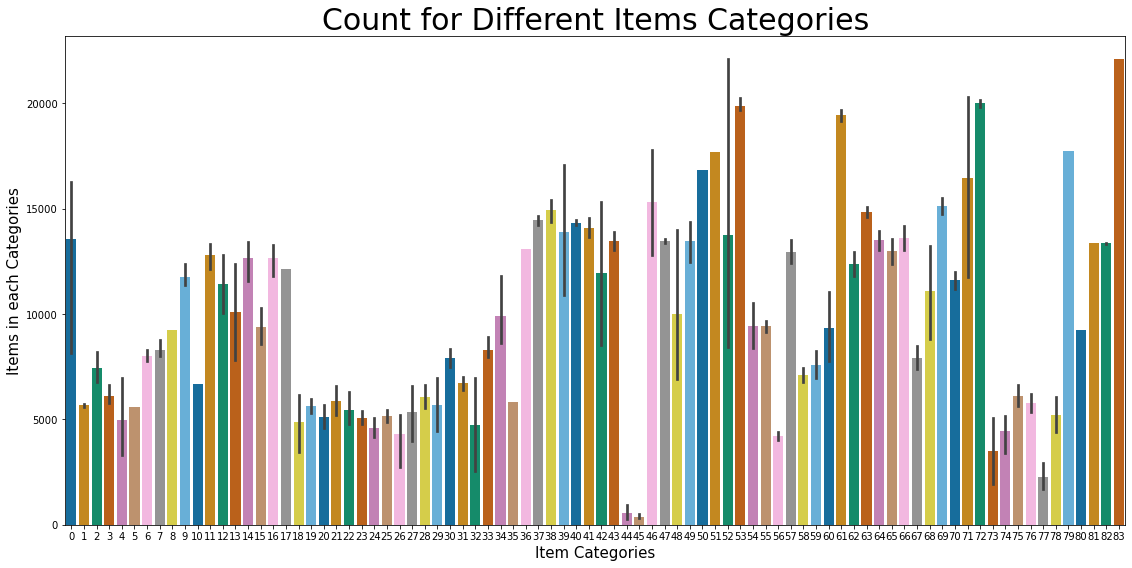

In [14]:
plt.rcParams['figure.figsize'] = (19, 9)
sns.barplot(items['item_category_id'], items['item_id'], palette = 'colorblind')
plt.title('Count for Different Items Categories', fontsize = 30)
plt.xlabel('Item Categories', fontsize = 15)
plt.ylabel('Items in each Categories', fontsize = 15)
plt.show()

/home/aiffel-dj56/anaconda3/envs/aiffel/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


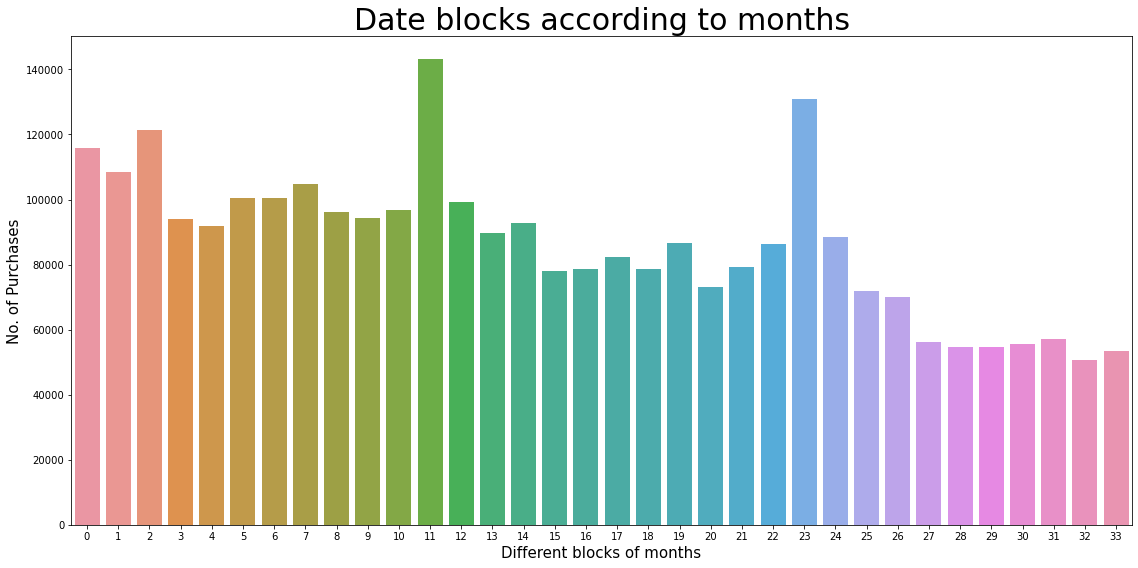

In [15]:
plt.rcParams['figure.figsize'] = (19, 9)
sns.countplot(train['date_block_num'])
plt.title('Date blocks according to months', fontsize = 30)
plt.xlabel('Different blocks of months', fontsize = 15)
plt.ylabel('No. of Purchases', fontsize = 15)
plt.show()

/home/aiffel-dj56/anaconda3/envs/aiffel/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


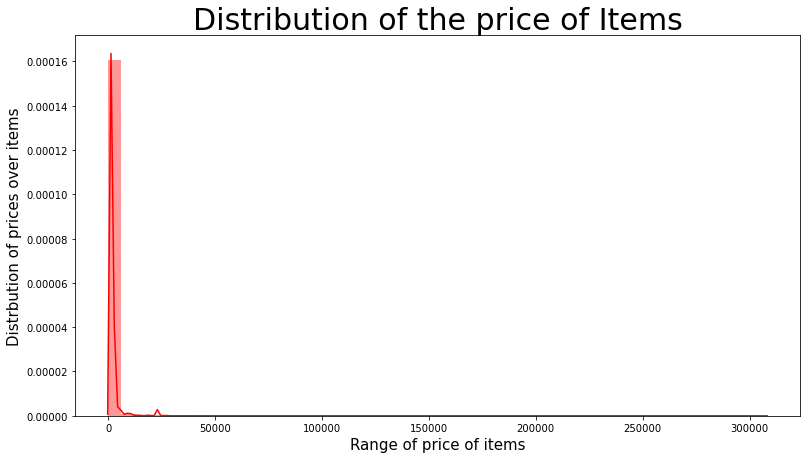

In [16]:
#하루에 판매되는 품목의 분포를 확인
plt.rcParams['figure.figsize'] = (13, 7)
sns.distplot(train['item_price'], color = 'red')
plt.title('Distribution of the price of Items', fontsize = 30)
plt.xlabel('Range of price of items', fontsize = 15)
plt.ylabel('Distrbution of prices over items', fontsize = 15)
plt.show()

/home/aiffel-dj56/anaconda3/envs/aiffel/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


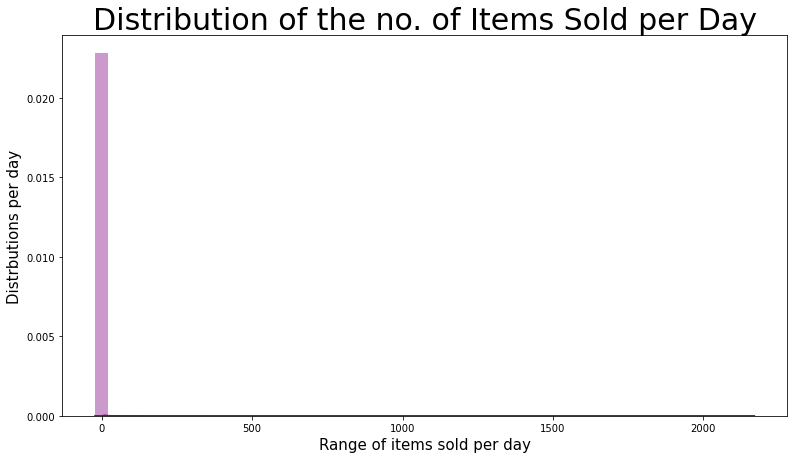

In [17]:
plt.rcParams['figure.figsize'] = (13, 7)
sns.distplot(train['item_cnt_day'], color = 'purple')
plt.title('Distribution of the no. of Items Sold per Day', fontsize = 30)
plt.xlabel('Range of items sold per day', fontsize = 15)
plt.ylabel('Distrbutions per day', fontsize = 15)
plt.show()

In [18]:
# checking the no. of unique item present in the stores
x = train['item_id'].nunique()
print("The No. of Unique Items Present in the stores available: ", x)

# checking the no. of unique item present in the stores
x = cats['item_category_id'].nunique()
print("The No. of Unique categories for Items Present in the stores available: ", x)

# checking the no. of unique shops given in the dataset
x = train['shop_id'].nunique()
print("No. of Unique Shops are :", x)


The No. of Unique Items Present in the stores available:  21807
The No. of Unique categories for Items Present in the stores available:  84
No. of Unique Shops are : 60


In [19]:
# making a new column day
train['day'] = train['date'].dt.strftime('%d')

# making a new column month
train['month'] = train['date'].dt.month

# making a new column year
train['year'] = train['date'].dt.year

# making a new column week
train['week'] = train['date'].dt.week

# checking the new columns
train.columns

/home/aiffel-dj56/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  # This is added back by InteractiveShellApp.init_path()


Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day', 'day', 'month', 'year', 'week'],
      dtype='object')

/home/aiffel-dj56/anaconda3/envs/aiffel/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


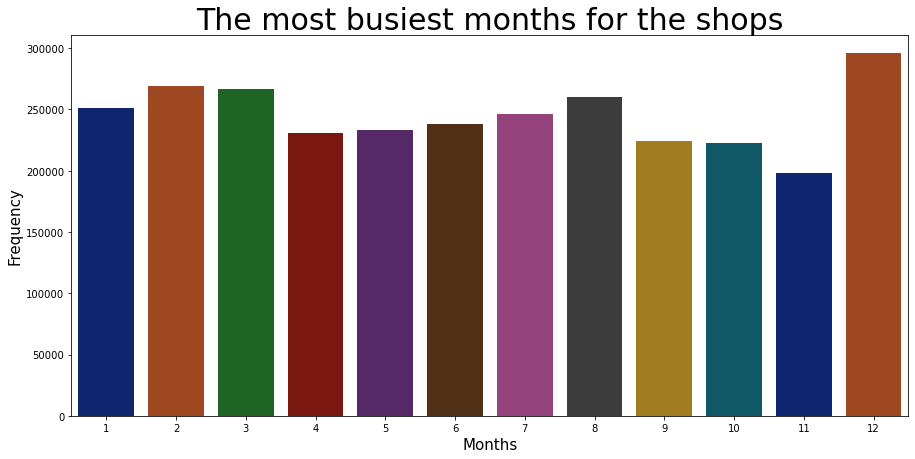

In [20]:
plt.rcParams['figure.figsize'] = (15, 7)
sns.countplot(train['month'], palette = 'dark')
plt.title('The most busiest months for the shops', fontsize = 30)
plt.xlabel('Months', fontsize = 15)
plt.ylabel('Frequency', fontsize = 15)

plt.show()

/home/aiffel-dj56/anaconda3/envs/aiffel/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


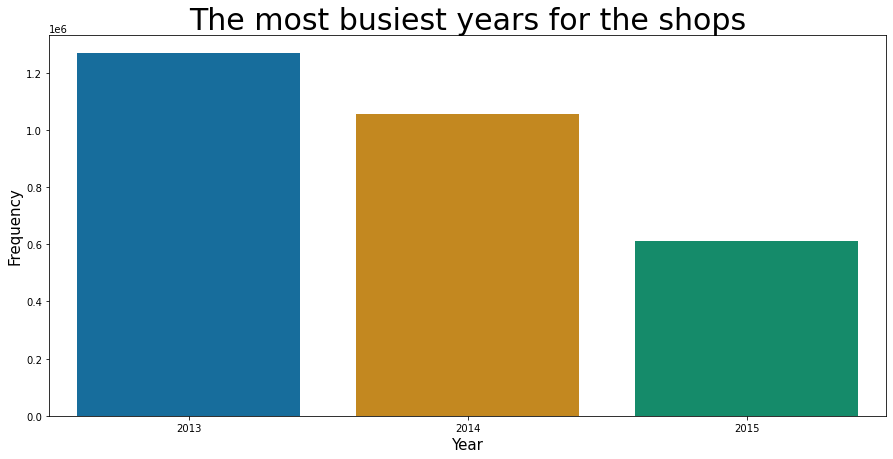

In [21]:
# checking which years are most busisiest for the shops

plt.rcParams['figure.figsize'] = (15, 7)
sns.countplot(train['year'], palette = 'colorblind')
plt.title('The most busiest years for the shops', fontsize = 30)
plt.xlabel('Year', fontsize = 15)
plt.ylabel('Frequency', fontsize = 15)

plt.show()

In [22]:
# checking the columns of the train data

train.columns

Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day', 'day', 'month', 'year', 'week'],
      dtype='object')

Outliers

/home/aiffel-dj56/anaconda3/envs/aiffel/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


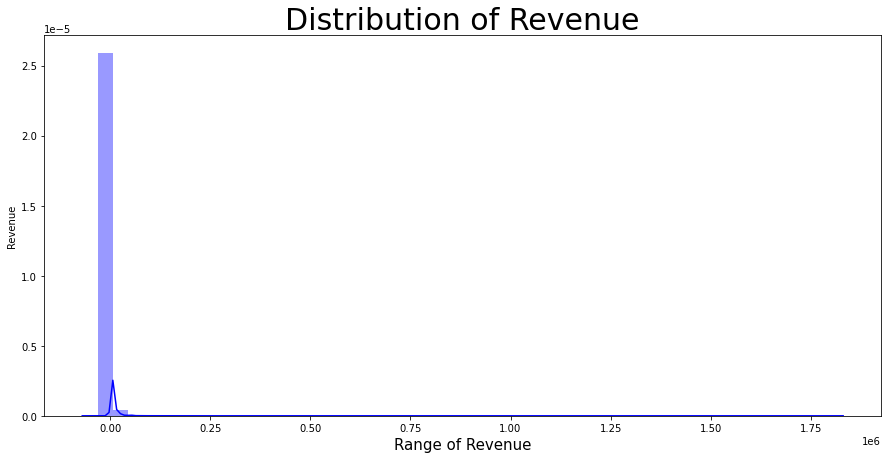

In [23]:
# feature engineering

train['revenue'] = train['item_price'] * train['item_cnt_day']

sns.distplot(train['revenue'], color = 'blue')
plt.title('Distribution of Revenue', fontsize = 30)
plt.xlabel('Range of Revenue', fontsize = 15)
plt.ylabel('Revenue')
plt.show()

In [24]:
train.dtypes

date              datetime64[ns]
date_block_num             int64
shop_id                    int64
item_id                    int64
item_price               float64
item_cnt_day             float64
day                       object
month                      int64
year                       int64
week                       int64
revenue                  float64
dtype: object

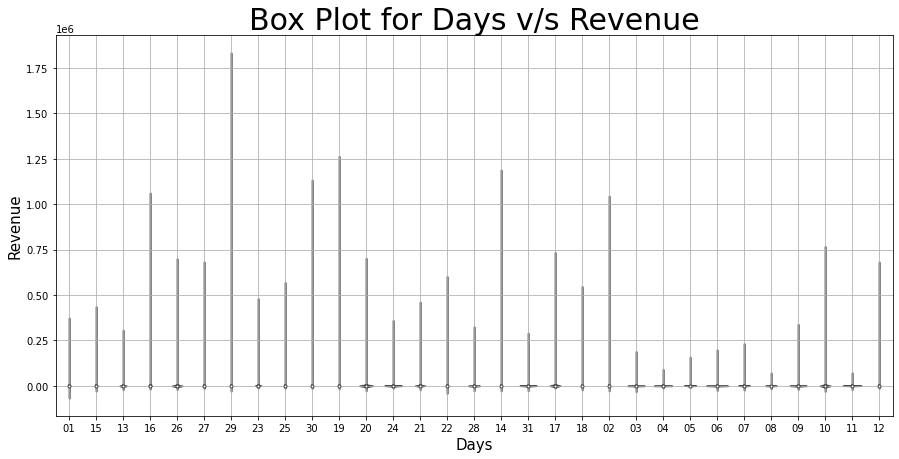

In [25]:
# plotting a box plot for itemprice and item-cnt-day

plt.rcParams['figure.figsize'] = (15, 7)
sns.violinplot(x = train['day'], y = train['revenue'])
plt.title('Box Plot for Days v/s Revenue', fontsize = 30)
plt.xlabel('Days', fontsize = 15)
plt.ylabel('Revenue', fontsize = 15)
plt.grid(True)
plt.show()

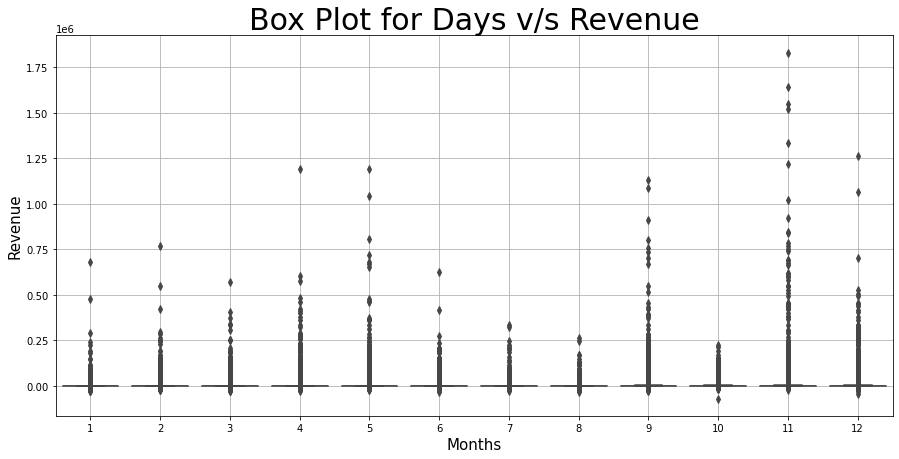

In [26]:
# plotting a box plot for itemprice and item-cnt-day

plt.rcParams['figure.figsize'] = (15, 7)
sns.boxplot(x = train['month'], y = train['revenue'])
plt.title('Box Plot for Days v/s Revenue', fontsize = 30)
plt.xlabel('Months', fontsize = 15)
plt.ylabel('Revenue', fontsize = 15)
plt.grid(True)
plt.show()

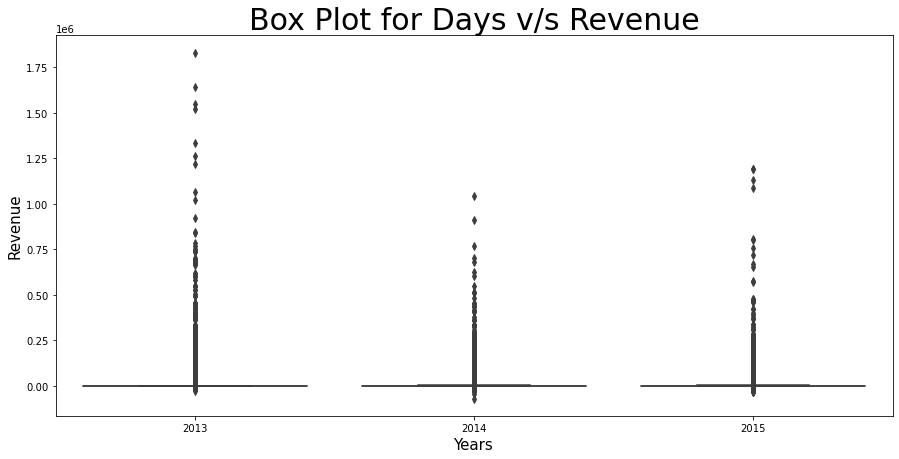

In [27]:
# plotting a box plot for itemprice and item-cnt-day

plt.rcParams['figure.figsize'] = (15, 7)
sns.boxplot(x = train['year'], y = train['revenue'])
plt.title('Box Plot for Days v/s Revenue', fontsize = 30)
plt.xlabel('Years', fontsize = 15)
plt.ylabel('Revenue', fontsize = 15)
plt.show()

## EDA 

<AxesSubplot:xlabel='item_price'>

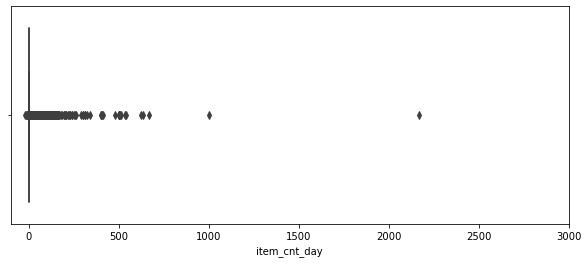

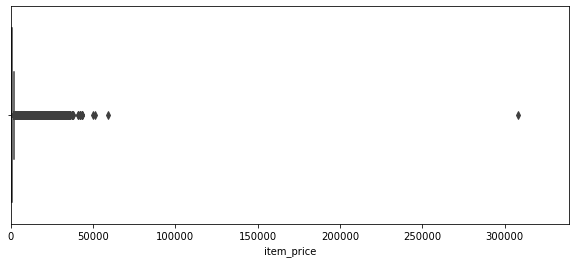

In [28]:
# Outliers
# remove items with price > 1000000 and sales > 1001
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=train.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price)

In [29]:
# remove outliers
train = train[train.item_price<100000]
train = train[train.item_cnt_day<1001]

In [30]:
# there is one item with price below 0, fill it with median
train[train.item_price<0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,day,month,year,week,revenue
484683,2013-05-15,4,32,2973,-1.0,1.0,15,5,2013,20,-1.0


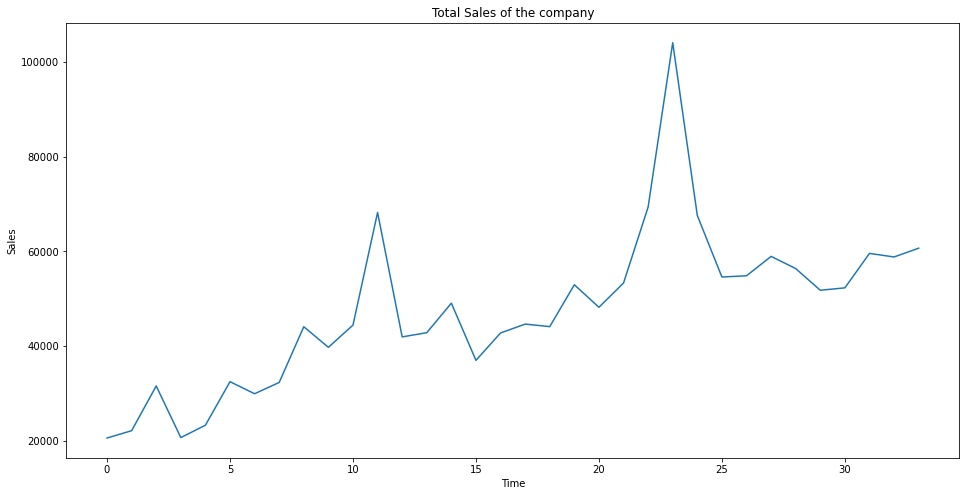

In [31]:
test_shops = test.shop_id.unique()
train = train[train.shop_id.isin(test_shops)]
test_items = test.item_id.unique()
train = train[train.item_id.isin(test_items)]

ts=train.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.astype('float')
plt.figure(figsize=(16,8))
plt.title('Total Sales of the company')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts);

/home/aiffel-dj56/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  


<Figure size 1152x864 with 0 Axes>

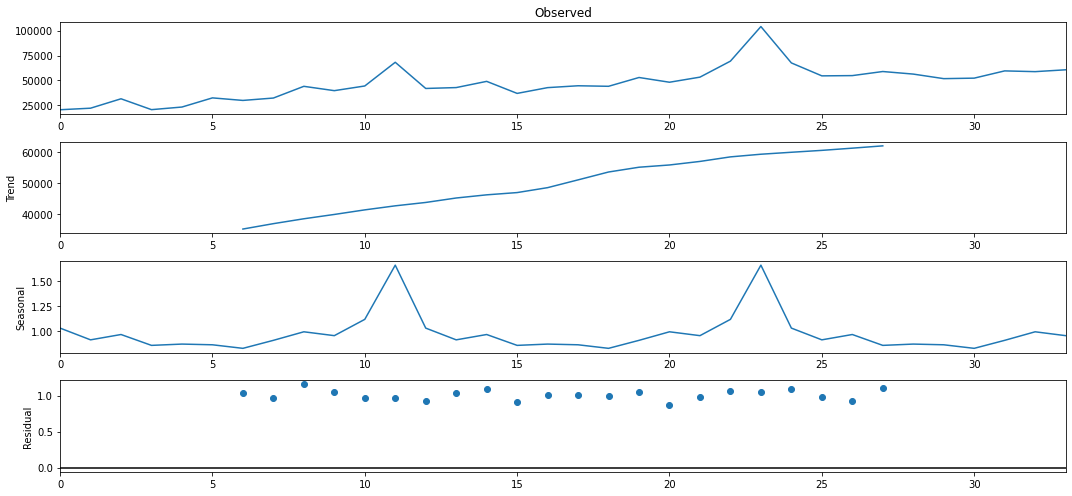

In [32]:
# multiplicative
res = sm.tsa.seasonal_decompose(ts.values,freq=12,model="multiplicative")
plt.figure(figsize=(16,12))
fig = res.plot()
#fig.show()

In [33]:
print(train.shape)

train['date'] = pd.to_datetime(train.date, format = '%d.%m.%Y')
train['day'] = train.date.dt.day
train['month'] = train.date.dt.month
train['year'] = train.date.dt.year
train['weekday'] = train.date.dt.dayofweek

train = train.merge(items, how = 'inner')
train.drop(['item_name'], inplace = True, axis = 1)
train['revenue'] = train['item_price'] * train['item_cnt_day']

print(train.shape)
train.head()

(1224438, 11)
(1224438, 13)


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,day,month,year,week,revenue,weekday,item_category_id
0,2013-02-01,0,59,22154,999.0,1.0,1,2,2013,5,999.0,4,37
1,2013-01-23,0,24,22154,999.0,1.0,23,1,2013,4,999.0,2,37
2,2013-02-01,0,25,22154,999.0,1.0,1,2,2013,5,999.0,4,37
3,2013-03-01,0,25,22154,999.0,1.0,1,3,2013,9,999.0,4,37
4,2013-01-20,0,25,22154,999.0,1.0,20,1,2013,3,999.0,6,37


In [34]:
median = train[(train.shop_id==32)&(train.item_id==2973)&(train.date_block_num==4)&(train.item_price>0)].item_price.median()
train.loc[train.item_price<0, 'item_price'] = median

In [35]:
# several shsops are duplicate, fix the train and test set
# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

###### Shops/Cats/Items preprocessing
- Each shop_name starts with the city name.
- Each category contains type and subtype in its name.

In [36]:
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
shops = shops[['shop_id','city_code']]

cats['split'] = cats['item_category_name'].str.split('-')
cats['type'] = cats['split'].map(lambda x: x[0].strip())
cats['type_code'] = LabelEncoder().fit_transform(cats['type'])
# if subtype is nan then type
cats['subtype'] = cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats['subtype_code'] = LabelEncoder().fit_transform(cats['subtype'])
cats = cats[['item_category_id','type_code', 'subtype_code']]

items.drop(['item_name'], axis=1, inplace=True)

In [37]:
len(list(set(test.item_id) - set(test.item_id).intersection(set(train.item_id)))), len(list(set(test.item_id))), len(test)

(384, 5100, 214200)

In [38]:
ts = time.time()
matrix = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sales = train[train.date_block_num==i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
    
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols,inplace=True)
print(time.time() - ts,  " 초 경과 !")

3.1410837173461914  초 경과 !


In [39]:
train['revenue'] = train['item_price'] *  train['item_cnt_day']

In [40]:
ts = time.time()
group = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=cols, how='left')
matrix['item_cnt_month'] = (matrix['item_cnt_month']
                                .fillna(0)
                                .clip(0,20) # NB clip target here
                                .astype(np.float16))
print(time.time() - ts,  " 초 경과 !")

0.8786687850952148  초 경과 !


In [41]:
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)

In [42]:
ts = time.time()
matrix = pd.concat([matrix, test], ignore_index=True, sort=False, keys=cols)
matrix.fillna(0, inplace=True) # 34 month
print(time.time() - ts,  " 초 경과 !")

0.017165422439575195  초 경과 !


In [43]:
ts = time.time()
matrix = pd.merge(matrix, shops, on=['shop_id'], how='left')
matrix = pd.merge(matrix, items, on=['item_id'], how='left')
matrix = pd.merge(matrix, cats, on=['item_category_id'], how='left')
matrix['city_code'] = matrix['city_code'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['type_code'] = matrix['type_code'].astype(np.int8)
matrix['subtype_code'] = matrix['subtype_code'].astype(np.int8)
print(time.time() - ts,  " 초 경과 !")

0.6817605495452881  초 경과 !


In [44]:
# Traget lag feature
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [45]:
ts = time.time()
matrix = lag_feature(matrix, [1,2,3,6,12], 'item_cnt_month')
print(time.time() - ts,  " 초 경과 !")

4.989904165267944  초 경과 !


In [46]:
# mean encoded features
ts = time.time()
group = matrix.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num'], how='left')
matrix['date_avg_item_cnt'] = matrix['date_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_avg_item_cnt')
matrix.drop(['date_avg_item_cnt'], axis=1, inplace=True)
print(time.time() - ts,  " 초 경과 !")

1.5824131965637207  초 경과 !


In [47]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_cnt'] = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_item_avg_item_cnt')
matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)
print(time.time() - ts,  " 초 경과 !")

6.013746738433838  초 경과 !


In [48]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_shop_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_avg_item_cnt'] = matrix['date_shop_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_shop_avg_item_cnt')
matrix.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)
print(time.time() - ts,  " 초 경과 !")

6.154307126998901  초 경과 !


In [49]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_cat_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_category_id'], how='left')
matrix['date_cat_avg_item_cnt'] = matrix['date_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_cat_avg_item_cnt')
print(time.time() - ts,  " 초 경과 !")

1.8771781921386719  초 경과 !


In [50]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_cat_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
matrix['date_shop_cat_avg_item_cnt'] = matrix['date_shop_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_cat_avg_item_cnt')
matrix.drop(['date_shop_cat_avg_item_cnt'], axis=1, inplace=True)
print(time.time() - ts,  " 초 경과 !")

2.0686261653900146  초 경과 !


In [51]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_type_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'type_code'], how='left')
matrix['date_shop_type_avg_item_cnt'] = matrix['date_shop_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_type_avg_item_cnt')
matrix.drop(['date_shop_type_avg_item_cnt'], axis=1, inplace=True)
print(time.time() - ts,  " 초 경과 !")

2.2736082077026367  초 경과 !


In [52]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_subtype_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'subtype_code'], how='left')
matrix['date_shop_subtype_avg_item_cnt'] = matrix['date_shop_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_subtype_avg_item_cnt')
matrix.drop(['date_shop_subtype_avg_item_cnt'], axis=1, inplace=True)
print(time.time() - ts,  " 초 경과 !")

2.2903897762298584  초 경과 !


In [53]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'city_code'], how='left')
matrix['date_city_avg_item_cnt'] = matrix['date_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_city_avg_item_cnt')
matrix.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)
print(time.time() - ts,  " 초 경과 !")

2.345348358154297  초 경과 !


In [54]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id', 'city_code'], how='left')
matrix['date_item_city_avg_item_cnt'] = matrix['date_item_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_item_city_avg_item_cnt')
matrix.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)
print(time.time() - ts,  " 초 경과 !")

3.2346370220184326  초 경과 !


In [55]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_type_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'type_code'], how='left')
matrix['date_type_avg_item_cnt'] = matrix['date_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_type_avg_item_cnt')
matrix.drop(['date_type_avg_item_cnt'], axis=1, inplace=True)
print(time.time() - ts,  " 초 경과 !")

2.334660768508911  초 경과 !


In [56]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_subtype_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'subtype_code'], how='left')
matrix['date_subtype_avg_item_cnt'] = matrix['date_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_subtype_avg_item_cnt')
matrix.drop(['date_subtype_avg_item_cnt'], axis=1, inplace=True)
print(time.time() - ts,  " 초 경과 !")

2.36198353767395  초 경과 !


Trend Features

In [57]:
ts = time.time()
group = train.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['item_id'], how='left')
matrix['item_avg_item_price'] = matrix['item_avg_item_price'].astype(np.float16)

group = train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_price'] = matrix['date_item_avg_item_price'].astype(np.float16)

lags = [1,2,3,4,5,6]
matrix = lag_feature(matrix, lags, 'date_item_avg_item_price')

for i in lags:
    matrix['delta_price_lag_'+str(i)] = \
        (matrix['date_item_avg_item_price_lag_'+str(i)] - matrix['item_avg_item_price']) / matrix['item_avg_item_price']

def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0
    
matrix['delta_price_lag'] = matrix.apply(select_trend, axis=1)
matrix['delta_price_lag'] = matrix['delta_price_lag'].astype(np.float16)
matrix['delta_price_lag'].fillna(0, inplace=True)

# https://stackoverflow.com/questions/31828240/first-non-null-value-per-row-from-a-list-of-pandas-columns/31828559
# matrix['price_trend'] = matrix[['delta_price_lag_1','delta_price_lag_2','delta_price_lag_3']].bfill(axis=1).iloc[:, 0]
# Invalid dtype for backfill_2d [float16]

fetures_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    fetures_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    fetures_to_drop += ['delta_price_lag_'+str(i)]

matrix.drop(fetures_to_drop, axis=1, inplace=True)

print(time.time() - ts,  " 초 경과 !")

47.51272535324097  초 경과 !


In [58]:
ts = time.time()
group = train.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
group.columns = ['date_shop_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)

group = group.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
group.columns = ['shop_avg_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['shop_id'], how='left')
matrix['shop_avg_revenue'] = matrix['shop_avg_revenue'].astype(np.float32)

matrix['delta_revenue'] = (matrix['date_shop_revenue'] - matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']
matrix['delta_revenue'] = matrix['delta_revenue'].astype(np.float16)

matrix = lag_feature(matrix, [1], 'delta_revenue')

matrix.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'], axis=1, inplace=True)
print(time.time() - ts,  " 초 경과 !")

3.0864768028259277  초 경과 !


In [59]:
#special features
matrix['month'] = matrix['date_block_num'] % 12

In [60]:
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix['days'] = matrix['month'].map(days).astype(np.int8)

In [61]:
ts = time.time()
cache = {}
matrix['item_shop_last_sale'] = -1
matrix['item_shop_last_sale'] = matrix['item_shop_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = str(row.item_id)+' '+str(row.shop_id)
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        matrix.at[idx, 'item_shop_last_sale'] = row.date_block_num - last_date_block_num
        cache[key] = row.date_block_num         
print(time.time() - ts,  " 초 경과 !")

310.77674102783203  초 경과 !


In [62]:
ts = time.time()
cache = {}
matrix['item_last_sale'] = -1
matrix['item_last_sale'] = matrix['item_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = row.item_id
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        if row.date_block_num>last_date_block_num:
            matrix.at[idx, 'item_last_sale'] = row.date_block_num - last_date_block_num
            cache[key] = row.date_block_num         
print(time.time() - ts,  " 초 경과 !")

199.34971737861633  초 경과 !


In [63]:
ts = time.time()
matrix['item_shop_first_sale'] = matrix['date_block_num'] - matrix.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
matrix['item_first_sale'] = matrix['date_block_num'] - matrix.groupby('item_id')['date_block_num'].transform('min')
print(time.time() - ts,  " 초 경과 !")

0.265514612197876  초 경과 !


In [64]:
# final preparations
ts = time.time()
matrix = matrix[matrix.date_block_num > 11]
print(time.time() - ts,  " 초 경과 !")

0.21851110458374023  초 경과 !


In [65]:
ts = time.time()
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)         
    return df

matrix = fill_na(matrix)
print(time.time() - ts,  " 초 경과 !")

0.45508861541748047  초 경과 !


In [66]:
matrix.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'city_code',
       'item_category_id', 'type_code', 'subtype_code', 'item_cnt_month_lag_1',
       'item_cnt_month_lag_2', 'item_cnt_month_lag_3', 'item_cnt_month_lag_6',
       'item_cnt_month_lag_12', 'date_avg_item_cnt_lag_1',
       'date_item_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_2',
       'date_item_avg_item_cnt_lag_3', 'date_item_avg_item_cnt_lag_6',
       'date_item_avg_item_cnt_lag_12', 'date_shop_avg_item_cnt_lag_1',
       'date_shop_avg_item_cnt_lag_2', 'date_shop_avg_item_cnt_lag_3',
       'date_shop_avg_item_cnt_lag_6', 'date_shop_avg_item_cnt_lag_12',
       'date_cat_avg_item_cnt', 'date_cat_avg_item_cnt_lag_1',
       'date_shop_cat_avg_item_cnt_lag_1', 'date_shop_type_avg_item_cnt_lag_1',
       'date_shop_subtype_avg_item_cnt_lag_1', 'date_city_avg_item_cnt_lag_1',
       'date_item_city_avg_item_cnt_lag_1', 'date_type_avg_item_cnt_lag_1',
       'date_subtype_avg_item_cnt_lag_1', 'delta_

In [67]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2439209 entries, 506809 to 2946017
Data columns (total 41 columns):
 #   Column                                Dtype  
---  ------                                -----  
 0   date_block_num                        int8   
 1   shop_id                               int8   
 2   item_id                               int16  
 3   item_cnt_month                        float16
 4   city_code                             int8   
 5   item_category_id                      int8   
 6   type_code                             int8   
 7   subtype_code                          int8   
 8   item_cnt_month_lag_1                  float16
 9   item_cnt_month_lag_2                  float16
 10  item_cnt_month_lag_3                  float16
 11  item_cnt_month_lag_6                  float16
 12  item_cnt_month_lag_12                 float16
 13  date_avg_item_cnt_lag_1               float16
 14  date_item_avg_item_cnt_lag_1          float16
 15  date_item_

In [68]:
matrix.to_pickle('data.pkl')
del matrix
del cache
del group
del items
del shops
del cats
del train
# leave test for submission
gc.collect();

# XGBoost

### 사용된 하이퍼 파라미터들

##### n_estimators  
* 의사 결정 트리의 수 (100~500), 대부분의 경우 특정값(100이나 200정도)을 넘어서는 트리를 추가해도 성능 향상 안 됨  
* 이유 : 부스트 된 트리 모델이 구성되는 방식으로, 각각의 새 트리가 순차적으로 이전 트리 시퀀스에서 발생한 오류를 모델링하고 수정하려고 시도하기 때문  
* 빠르게 모델은 수익이 감소하는 지점에 도달  
* default = 100 (주로 50부터 50단위로 확인/비교) : 논문에서 권장하는 값

#####  max_depth  
* 의사 결정 트리의 크기 (레이어 수, 깊이)  
* 얕은 트리는 문제의 세부 사항을 거의 포착하지 않고 일반적으로 약한 학습자라고 불리기 때문에 성능이 떨어질 것으로 예상  
* 더 깊은 트리는 일반적으로 문제의 너무 많은 세부 정보를 캡처하고 훈련 데이터셋을 과적 합하여 새 데이터에 대하여 좋은 예측을 할 수 있는 능력을 제한  
* default = 3 (정수) : 논문 등에서 권장하는 값  
* 예) 1, 3, 5, 7, 9, ... 이런 식으로 확인

#####  min_child_weight  
* child에게 필요한 instance weight(= hessian)의 최소 합계  
* 트리 분할 단계에서 instance weight의 합이 min_child_weight보다 작은 leaf node가 생성되면 building process에서 더 이상의 분할을 하지 않음  
* 선형 회귀 작업에서 이는 단순히 각 노드에 있어야 하는 최소 인스턴스 수에 해당  
* 이 값이 클수록 알고리즘이 더 conservative

#####  colsample_bytree  
* column들의 서브샘플링에 대한 파라미터  
* 각 트리를 구성 할 때 열(column)의 하위 표본 비율  
* 서브 샘플링은 구성된 모든 트리에 대해 한 번 발생  
* default = 1

##### subsample = 1 (default) : 논문에선 이걸 추천한다고 함

##### XGBoost 에서 지원하는 평가 지표들 (이 외에도 가능)
* rmse : 평균 제곱근 오차, root mean squared error  
* mae : mean absolute error  
* logloss : binary logarithmic loss  
* mlogloss : multi-class log loss (cross entropy)
* error : 분류 오류, classification error
* auc : ROC 곡선 아래의 영역, area under ROC curve

### XGBoost 모델 피팅
* eval_metric 인수 에 x, y 쌍의 배열 제공  
* 테스트셋 외에도 학습데이터셋을 제공할 수도 있고, 그러면 학습 중에 학습/테스트셋 각각에서 모델이 얼마나 잘 수행되고 있는지 확인 가능  
* 각 평가 집합에 대한 모델의 성능이 저장되고 `model.evals_result()` 함수를 호출하여 학습 후 모델에서 사용 가능
* 이렇게 하면 evaluation 데이터셋의 dictionary 반환  
* `validation_0` 과 `validation_1` 각각은 `fit()` 호출에서 데이터셋이 eval_set 인수에 제공하는 순서에 해당
* 첫 번째 데이터셋 및 오류 측정 항목과 같은 특정 결과 배열은 `results['validation_0']['error']`으로 액세스  
* `early_stopping_rounds` : 개선이 관찰되지 않는 Epoch 수의 창을 지정하여 이 값만큼 횟수를 반복 후 조기 중지 지원  
* 여러 평가 데이터셋이나 여러 평가 메트릭이 제공되는 경우 조기 중지는 목록의 마지막 항목에 사용

In [69]:
import numpy as np
import pandas as pd
import time
import sys
import gc
import pickle

data = pd.read_pickle('data.pkl')

In [70]:
data = data[[
    'date_block_num',
    'shop_id',
    'item_id',
    'item_cnt_month',
    'city_code',
    'item_category_id',
    'type_code',
    'subtype_code',
    'item_cnt_month_lag_1',
    'item_cnt_month_lag_2',
    'item_cnt_month_lag_3',
    'item_cnt_month_lag_6',
    'item_cnt_month_lag_12',
    'date_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_2',
    'date_item_avg_item_cnt_lag_3',
    'date_item_avg_item_cnt_lag_6',
    'date_item_avg_item_cnt_lag_12',
    'date_shop_avg_item_cnt_lag_1',
    'date_shop_avg_item_cnt_lag_2',
    'date_shop_avg_item_cnt_lag_3',
    'date_shop_avg_item_cnt_lag_6',
    'date_shop_avg_item_cnt_lag_12',
    'date_cat_avg_item_cnt_lag_1',
    'date_shop_cat_avg_item_cnt_lag_1',
    #'date_shop_type_avg_item_cnt_lag_1',
    #'date_shop_subtype_avg_item_cnt_lag_1',
    'date_city_avg_item_cnt_lag_1',
    'date_item_city_avg_item_cnt_lag_1',
    #'date_type_avg_item_cnt_lag_1',
    #'date_subtype_avg_item_cnt_lag_1',
    'delta_price_lag',
    'month',
    'days',
    'item_shop_last_sale',
    'item_last_sale',
    'item_shop_first_sale',
    'item_first_sale',
]]

In [71]:
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [72]:
del data
gc.collect();

In [73]:
#xgboost 모델 학습 
import time
import xgboost as xgb
from xgboost import XGBRegressor

ts = time.time()

model = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=20)

clf = model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)

print(time.time() - ts,  " 초 경과 !")

[0]	validation_0-rmse:1.37078	validation_1-rmse:1.09212
[1]	validation_0-rmse:1.24280	validation_1-rmse:1.01345
[2]	validation_0-rmse:1.16932	validation_1-rmse:0.97000
[3]	validation_0-rmse:1.12604	validation_1-rmse:0.95439
[4]	validation_0-rmse:1.09979	validation_1-rmse:0.94152
[5]	validation_0-rmse:1.07949	validation_1-rmse:0.94319
[6]	validation_0-rmse:1.06505	validation_1-rmse:0.93896
[7]	validation_0-rmse:1.05713	validation_1-rmse:0.93781
[8]	validation_0-rmse:1.05062	validation_1-rmse:0.93872
[9]	validation_0-rmse:1.04602	validation_1-rmse:0.94115
[10]	validation_0-rmse:1.04326	validation_1-rmse:0.94096
[11]	validation_0-rmse:1.03837	validation_1-rmse:0.94111
[12]	validation_0-rmse:1.03306	validation_1-rmse:0.94068
[13]	validation_0-rmse:1.03188	validation_1-rmse:0.94085
[14]	validation_0-rmse:1.02926	validation_1-rmse:0.94026
[15]	validation_0-rmse:1.02725	validation_1-rmse:0.94114
[16]	validation_0-rmse:1.02612	validation_1-rmse:0.94122
[17]	validation_0-rmse:1.02457	validation

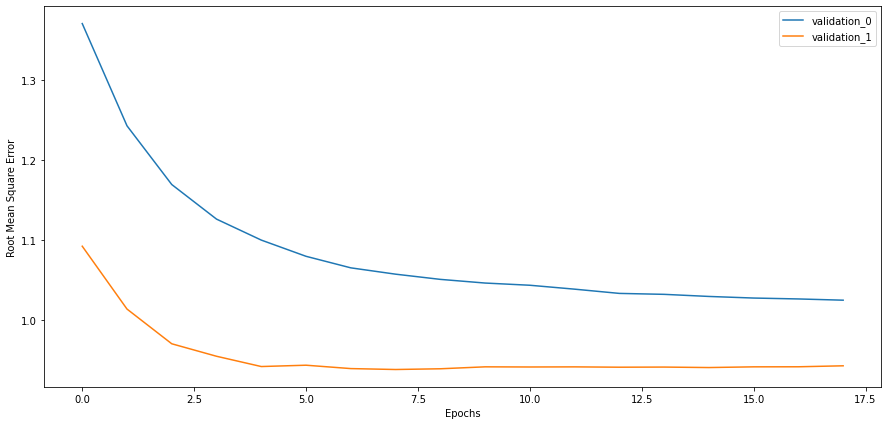

<Figure size 1080x504 with 0 Axes>

In [74]:
#xgboost 모델 학습 결과 그래프로 확인
#clf.evals_result()
results = clf.evals_result()
epochs = len(results['validation_0']['rmse'])

plt.plot(results['validation_0']['rmse'], label='validation_0')
plt.plot(results['validation_1']['rmse'], label='validation_1')
plt.xlabel("Epochs")
plt.ylabel("Root Mean Square Error")
plt.legend()
plt.show()
plt.savefig("Validations RMSE Progression.png")

In [75]:
#xgboost 모델 학습 예측 
Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('xgb_submission.csv', index=False)

# save predictions for an ensemble
pickle.dump(Y_pred, open('xgb_train.pickle', 'wb'))
pickle.dump(Y_test, open('xgb_test.pickle', 'wb'))

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

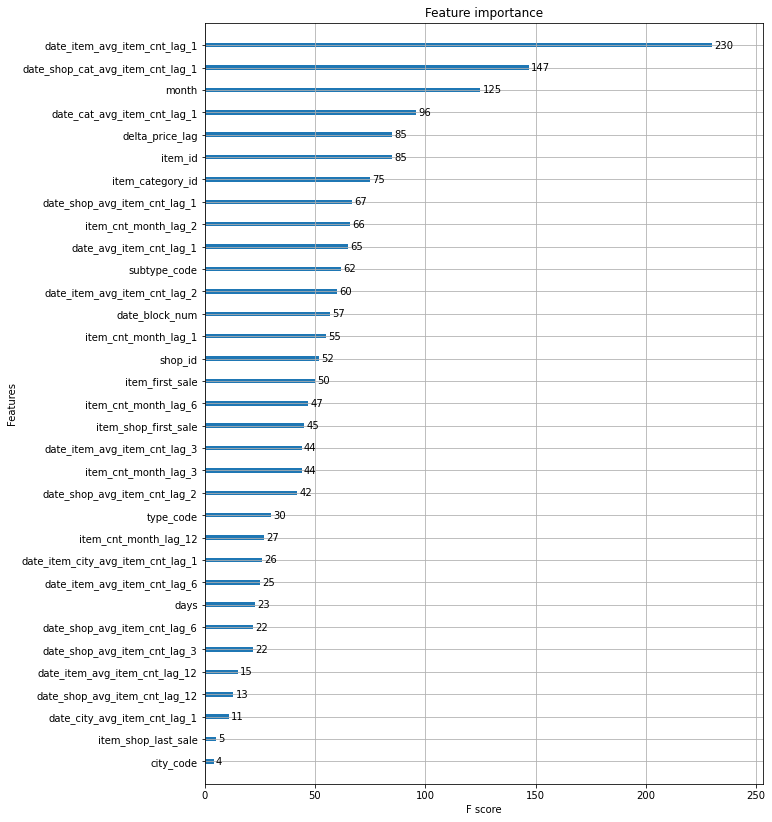

In [76]:
plot_features(model, (10,14))

# LSTM

* LSTM (Long Short-Term Memory) 네트워크는 시계열 예측에 적용  
* 유형별 시계열 예측 문제에 사용 가능한 다양한 타입 존재

### 유형별 LSTM 모델의 종류

##### Univariate LSTM Models (일변수 모델)
* 일련의 단일 관측치로 구성된 문제, 과거 관측치로부터 학습하여 시퀀스의 다음 값 예측
* `model.compile(optimizer='adam', loss='mse')`
  
__일변수 모델 종류__
* Vanilla LSTM : 단일 히든 레이어, 예측에 사용되는 출력 레이어  
* Stacked LSTM (스택형) : 여러 개의 히든 스택형 레이어를 다른 스택형 레이어에 쌓을 수 있음  
* Bidirectional LSTM (양방향) : 입력 시퀀스를 앞뒤로 학습하고 두 해석을 상호 연결, 일변수 시계열 예측을 위해 첫 번째 히든레이어를 양방향 레이어로 감싸는 형식  
* CNN LSTM (Convolution neural network) : 2차원 이미지 데이터,일변수 시계열 데이터처럼 1차원 시퀀스 데이터에서의 feature를 자동으로 추출하여 학습하는 데 효과적 
* ConvLSTM : CNN-LSTM 과 관련된 유형, 입력된 컨볼루션 판독값이 각 LSTM unit에 직접 내장, 2차원 spatial-temporal data를 읽기 위해 개발됐지만 일변수 시계열 예측과 함께 사용하도록 조정 가능

##### Multivariate LSTM Models (다변수 모델)  
* 다변수 시계열 데이터 : 각 시간별로 둘 이상의 관측치가 있는 데이터를 의미  
  
__다변수 모델 종류__  
* Multiple Input Series (다중 입력 시리즈)  
* Multiple Parallel Series (다중 병렬 시리즈)

##### Multi-Step LSTM Models (다단계 모델)  
* 다단계 시계열 예측 : 미래의 여러 시간 단계를 예측해야 하는 문제. 특히, 예측 기간 또는 구간이 2-time step 이상인 문제  
  
__다단계 모델 종류__  
* Vector Output Model (벡터 출력 모델)    
* Encoder-Decoder Model (인코더-디코더 모델)

##### Multivariate Multi-Step LSTM Models (다변수 다단계 모델)
* 위의 다양한 문제들에 제시된 유형들을 혼합  
  
__다변수 다단계 모델 종류__  
* Multiple Input Multi-Step Output (다중 입력 다단계 출력)  
* Multiple Parallel Input and Multi-Step Output (다중 병렬입력 및 다중단계 출력)

In [77]:
print(X_train.values.shape)

print(Y_train.values.shape)

print(X_valid.values.shape)

print(Y_valid.values.shape)

print(X_test.shape)

(2058899, 34)
(2058899,)
(166110, 34)
(166110,)
(214200, 34)


In [78]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation, ThresholdedReLU, MaxPooling2D, Embedding, Dropout
from keras.optimizers import Adam, SGD, RMSprop
from keras import backend as K
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
import gc

In [79]:
X_train=X_train.values.reshape((X_train.shape[0],X_train.shape[1],1))
X_valid=X_valid.values.reshape((X_valid.shape[0],X_valid.shape[1],1))

Y_train=Y_train.values.reshape((Y_train.shape[0],1))
Y_valid=Y_valid.values.reshape((Y_valid.shape[0],1))

X_test=X_test.values.reshape((X_test.shape[0],X_test.shape[1],1))

In [80]:
K.clear_session()
model_lstm = Sequential()
model_lstm.add(LSTM(16, input_shape=(X_train.shape[1], X_train.shape[2]),return_sequences=True))
model_lstm.add(Dropout(0.5))
model_lstm.add(LSTM(32))
model_lstm.add(Dropout(0.5))
model_lstm.add(Dense(8))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer="adam", loss='mse', metrics=["mse"])
print(model_lstm.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 34, 16)            1152      
_________________________________________________________________
dropout (Dropout)            (None, 34, 16)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                6272      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 264       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 7,697
Trainable params: 7,697
Non-trainable params: 0
______________________________________________________

Epoch 1/10
2011/2011 [==============================] - 12s 6ms/step - loss: 1.3268 - mse: 1.3268 - val_loss: 0.9978 - val_mse: 0.9978
Epoch 2/10
2011/2011 [==============================] - 12s 6ms/step - loss: 1.3159 - mse: 1.3159 - val_loss: 0.9632 - val_mse: 0.9632
Epoch 3/10
2011/2011 [==============================] - 12s 6ms/step - loss: 1.3110 - mse: 1.3110 - val_loss: 0.9229 - val_mse: 0.9229
Epoch 4/10
2011/2011 [==============================] - 12s 6ms/step - loss: 1.3112 - mse: 1.3112 - val_loss: 0.9390 - val_mse: 0.9390
Epoch 5/10
2011/2011 [==============================] - 12s 6ms/step - loss: 1.3089 - mse: 1.3089 - val_loss: 0.9145 - val_mse: 0.9145
Epoch 6/10
2011/2011 [==============================] - 12s 6ms/step - loss: 1.3047 - mse: 1.3047 - val_loss: 0.9116 - val_mse: 0.9116
Epoch 7/10
2011/2011 [==============================] - 12s 6ms/step - loss: 1.3053 - mse: 1.3053 - val_loss: 0.9224 - val_mse: 0.9224
Epoch 8/10
2011/2011 [==============================] -

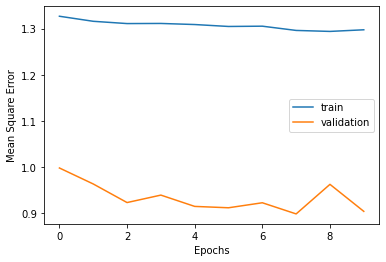

<Figure size 432x288 with 0 Axes>

In [85]:
import matplotlib.pyplot as plt
%matplotlib inline

LSTM_PARAM = {"batch_size":1024,
              "verbose":1,
              "epochs":10}

    
callbacks_list=[EarlyStopping(monitor="val_loss",min_delta=.001, patience=20,mode='auto')]
hist = model_lstm.fit(X_train, Y_train,validation_data=(X_valid, Y_valid),callbacks=callbacks_list, **LSTM_PARAM)
pred = model_lstm.predict(X_test)

# Model Evaluation
best = np.argmin(hist.history["val_loss"])
print("Optimal Epoch: {}",best)
print("Train Score: {}, Validation Score: {}".format(hist.history["loss"][best],hist.history["val_loss"][best]))

plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.xlabel("Epochs")
plt.ylabel("Mean Square Error")
plt.legend()
plt.show()
plt.savefig("Train and Validation MSE Progression.png")

In [82]:
submission = pd.DataFrame(pred,columns=['item_cnt_month'])
submission.to_csv('lstm_submission.csv',index_label='ID')